# Extensive deep neural network tutorial

In this series we will build an Extensive Deep Neural Network (EDNN) capable of predicting extensive physical properties on two-dimensional images.  We will demonstrate how to use the trained model to achieve $\mathcal{O}(N)$ scaling with respect to the image size.

This technique was first introduced in "Extensive Deep Neural Networks" by I. Luchak, K. Mills, K. Ryczko, et. al.
(https://arxiv.org/abs/1708.06686)



## 1) The Ising model of magnetization

In this post we'll step up our game a bit and move on to a more challenging problem: the Ising model of magnetization.  This will allow us to demonstrate the importance of context, and the ability of an extensive deep neural network to make predictions on images larger than that on which it was trained.

First, a brief overview: The Ising model defined on an infinite domain (i.e. periodic boundary conditions) is an example of a simple physical model of magnetization.  All we need to know for this tutorial is that there are up and down spins, and when two neighbouring are pointing in the same direction, it's good. When they're pointing opposite one another, that's bad.  In physics, "good" means a low energy, and "bad" means a high energy. For more information about the Ising model and deep learning, you can check out my previous paper here https://arxiv.org/pdf/1706.09779.pdf, and the references listed therein.

Now, we could just generate random Ising model configurations, but for reasons we've discussed in https://arxiv.org/pdf/1706.09779.pdf, the best bet is to use a physical simulation to sample evenly across energies. This has nothing to do with EDNNs, so to keep this relevant, we'll load the data from a file.

In [1]:
#First, some imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import h5py
%matplotlib inline

/home/kmills/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def get_data(N):
    assert N<=25000, "N must be less than 25000"
    with h5py.File("./ising_data.h5",'r') as F:
        data = F['data'][:N, ...,0]*1.0
        label = F['energy'][:N, ...]*1.0
    return data, label

Let us take a look at some of the training data.


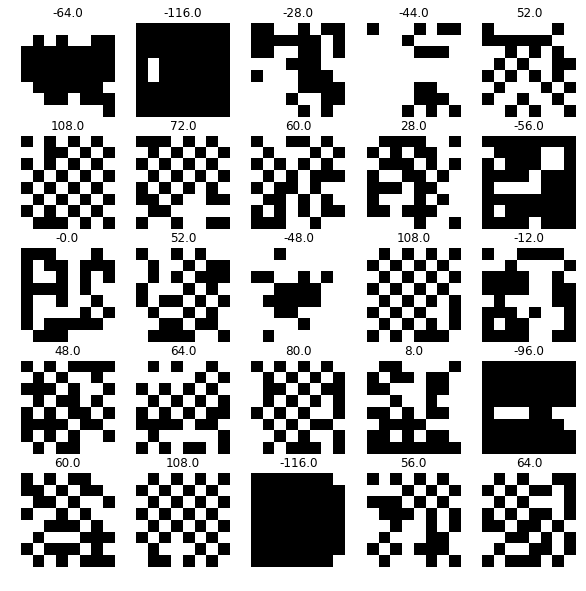

In [5]:
data, labels =  get_data(25)

fig, axs = plt.subplots(5,5,figsize=(10,10))

for i in range(5):
    for j in range(5):
        axs[i][j].imshow(data[5*i+j,:,:], cmap='gray')
        axs[i][j].set_title('{0}'.format(labels[5*i+j][0]))
        axs[i][j].axis("off")

Notice that the images (which we will call "configurations") that have large regions of black or white (i.e. aligned spins) have much lower energies than those with checkerboard patterns.

Next we need to decide on the focus and context that we will use.  We know from the model that was used to calculate the labels, only nearest-neighbour interactions matter, therefore, $f=1, c=1$ is the best choice for the Ising model.

Let's try this out first:

In [6]:
L = 8
f = 1
c = 1

Next we'll define a few functions to help us.  These are identical to the previous tutorial.

In [7]:
def roll(in_, num, axis):
    """author: Kyle Mills"""
    D = tf.transpose(in_, perm=[axis, 1-axis])  #if axis=1, transpose first
    D = tf.concat([D[num:, :], D[0:num, :]], axis=0)
    return tf.transpose(D, perm=[axis, 1-axis]) #if axis=1, transpose back

def slice_(in_, x1, y1, w, h): 
    """author: Kyle Mills"""
    return in_[x1:x1+w, y1:y1+h]

def ednn_split(in_): 
    """author: Kyle Mills"""
    l = L
    #alternatively, a (probably better) way to get l is to do:
    #   l = in_.get_shape().as_list()[0]
   
    tiles = []
    for iTile in range(l/f):
        for jTile in range(l/f):
            #calculate the indices of the centre of this tile (i.e. the centre of the focus region)
            cot = (iTile*f + f/2, jTile*f + f/2) #centre of tile
            foc_centered = in_ 
            #shift the picture, wrapping the image around,
            #so that the focus is centered in the middle of the image
            foc_centered = roll(foc_centered, l/2-cot[0], 0)
            foc_centered = roll(foc_centered, l/2-cot[1], 1)
            #Finally slice away the excess image that we don't want to appear in this tile
            final = slice_(foc_centered, l/2-f/2-c, l/2-f/2-c, 2*c+f, 2*c+f)
            tiles.append(final)
            
    return tf.expand_dims(tiles, axis=3)


Next we will define the neural network.  Notice that this is done no differently than a normal neural network.  This time, because we're using a focus of 1 and a context of 1, the neural network is only receiving a $3\times 3$ image. We'll use a very simple neural network:

In [8]:
def NN(_in):
    tile_size = f + 2*c
    _in = tf.reshape(_in, (-1, tile_size**2))
    lay1 = tf.contrib.layers.fully_connected(_in, 64)
    lay2 = tf.contrib.layers.fully_connected(lay1, 1, activation_fn=None)
    return lay2

Now we'll build the graph just as we did in the previous tutorial. This takes a long time; a consequence of using a small focus region is that we need many tiles to cover our whole image. 

In [9]:
#data comes in a [ batch * L * L ] tensor, and labels a [ batch * 1] tensor
x = tf.placeholder(tf.float32, (None, L, L), name='input_image')
y = tf.placeholder(tf.float32, (None, 1))

#Then the EDNN-specific code:
tiles = tf.map_fn(ednn_split, x, back_prop=False)
tiles = tf.transpose(tiles, perm=[1,0,2,3,4])
output = tf.map_fn(NN, tiles, back_prop=True)
output = tf.transpose(output, perm=[1,0,2])
predicted = tf.reduce_sum(output, axis=1)


#define the loss function
loss = tf.reduce_mean(tf.square(y-predicted))

#create an optimizer, a training op, and an init op
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [10]:
sess = tf.InteractiveSession()
sess.run(init)

We will get 1000 data points, and split it into training and testing datasets with a 9/1 ratio:

In [11]:
data, labels = get_data(1000)
train_data = data[:900]
test_data = data[900:]
train_labels = labels[:900]
test_labels = labels[900:]

In [24]:
BATCH_SIZE = 100

bar = progressbar.ProgressBar()
for epoch in bar(range(1000)):
    for batch in xrange(train_data.shape[0] / BATCH_SIZE):
        _, loss_val = sess.run([train_step, loss],
                               feed_dict={
                                    x: train_data[batch*BATCH_SIZE:batch*(BATCH_SIZE+1)],
                                    y: labels[batch*BATCH_SIZE:batch*(BATCH_SIZE+1)]
                                }
                              )


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38


In [25]:
prediction = sess.run(predicted, feed_dict={x: test_data})

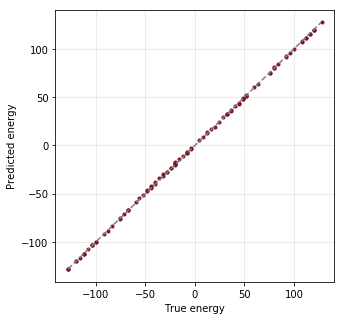

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
ax.plot(np.arange(-128,128), np.arange(-128,128), '--', color='gray')
ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.3)

It works!  But let's quantify how well it works by computing the median absolute error:

In [29]:
error = {}
error["f1c1"] = np.median(np.abs(test_labels - prediction))
print error

{'f1c1': 0.5492186546325684}
